# 逻辑回归

 **学习目标：**
  * 将（在之前的练习中构建的）房屋价值中位数预测模型重新构建为二元分类模型
  * 比较逻辑回归与线性回归解决二元分类问题的有效性

与在之前的练习中一样，我们将使用加利福尼亚州住房数据集，但这次我们会预测某个城市街区的住房成本是否高昂，从而将其转换成一个二元分类问题。此外，我们还会暂时恢复使用默认特征。

## 将问题构建为二元分类问题

数据集的目标是 `median_house_value`，它是一个数值（连续值）特征。我们可以通过向此连续值使用阈值来创建一个布尔值标签。

我们希望通过某个城市街区的特征预测该街区的住房成本是否高昂。为了给训练数据和评估数据准备目标，我们针对房屋价值中位数定义了分类阈值 - 第 75 百分位数（约为 265000）。所有高于此阈值的房屋价值标记为 `1`，其他值标记为 `0`。

## 设置

In [43]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

注意：以下代码与之前代码稍有不同。我们并没有将 median_house_value 用作目标，而是创建了一个新的二元目标 median_house_value_is_high。

In [44]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

In [45]:
# 训练集
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# 验证集
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2647.0,540.7,1428.5,502.1,3.9,2.0
std,2.1,2.0,12.5,2205.6,426.1,1169.6,389.3,1.9,1.3
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1454.0,295.0,787.8,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.5,433.0,1165.0,407.0,3.6,1.9
75%,37.7,-118.0,37.0,3155.0,648.0,1717.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.7,2635.7,536.3,1432.2,499.2,3.9,2.0
std,2.1,2.0,12.7,2117.3,410.3,1094.0,372.8,1.9,0.9
min,32.5,-124.3,1.0,15.0,3.0,3.0,3.0,0.5,0.0
25%,33.9,-121.8,18.0,1476.0,301.0,793.0,284.8,2.6,1.5
50%,34.3,-118.5,29.0,2134.5,436.0,1175.5,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3136.2,650.0,1733.0,607.0,4.7,2.3
max,41.9,-114.5,52.0,32054.0,5290.0,15507.0,5050.0,15.0,29.4


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


## 线性回归

为了解逻辑回归为什么有效，我们首先训练一个使用线性回归的简单模型。该模型将使用 {0, 1} 中的值为标签，并尝试预测一个尽可能接近 0 或 1 的连续值。此外，我们希望将输出解读为概率，所以最好模型的输出值可以位于 (0, 1) 范围内。然后我们会应用阈值 0.5，以确定标签。

In [46]:
def construct_feature_columns(input_features):
    
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

In [47]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [48]:
%matplotlib inline
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    
    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )

    # 1. Create input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value_is_high"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value_is_high"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value_is_high"], 
        num_epochs=1, 
        shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.48
  period 01 : 0.48
  period 02 : 0.47
  period 03 : 0.47
  period 04 : 0.46
  period 05 : 0.46
  period 06 : 0.46
  period 07 : 0.46
  period 08 : 0.46
  period 09 : 0.46
Model training finished.


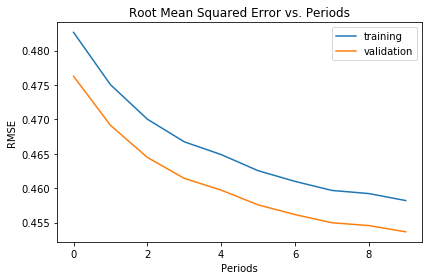

In [49]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 计算预测的对数损失函数


`LinearRegressor` 使用的是 L2 损失，在将输出解读为概率时，它并不能有效地惩罚误分类。例如，对于概率分别为 0.9 和 0.9999 的负分类样本是否被分类为正分类，二者之间的差异应该很大，但 L2 损失并不会明显区分这些情况。

相比之下，`LogLoss`（对数损失函数）对这些"置信错误"的惩罚力度更大。请注意，`LogLoss` 的定义如下：

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


但我们首先需要获得预测值。我们可以使用 `LinearRegressor.predict` 获得预测值。

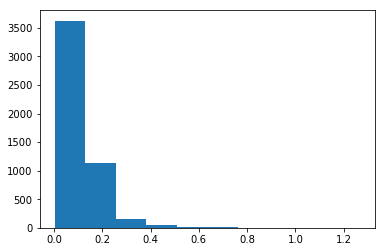

In [50]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                 validation_targets['median_house_value_is_high'],
                                                 num_epochs=1,
                                                 shuffle=False)
validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

 ## 任务 2：训练逻辑回归模型并计算验证集的对数损失函数

要使用逻辑回归非常简单，用 [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) 替代 `LinearRegressor` 即可。

**注意**：在 `LinearClassifier` 模型上运行 `train()` 和 `predict()` 时，您可以通过返回的字典（例如 `predictions["probabilities"]`）中的 `"probabilities"` 键获取实值预测概率。Sklearn 的 [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) 函数可基于这些概率计算对数损失函数，非常方便。

In [51]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    
    periods = 10
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )

    # 1. Create input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value_is_high"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value_is_high"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value_is_high"], 
        num_epochs=1, 
        shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions.
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)

        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_log_loss))
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.65
  period 01 : 0.63
  period 02 : 0.63
  period 03 : 0.62
  period 04 : 0.62
  period 05 : 0.62
  period 06 : 0.62
  period 07 : 0.62
  period 08 : 0.61
  period 09 : 0.61
Model training finished.


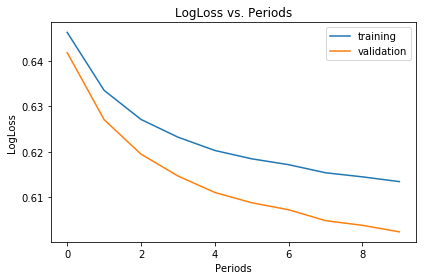

In [52]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 3：计算准确率并为验证集绘制 ROC 曲线

分类时非常有用的一些指标包括：模型[准确率](http://charleshm.github.io/2016/03/Model-Performance/)、ROC 曲线和 ROC 曲线下面积 (AUC)。我们会检查这些指标。

`LinearClassifier.evaluate` 可计算准确率和 AUC 等实用指标。

In [53]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.48
Accuracy on the validation set: 0.76


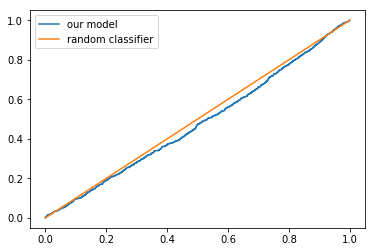

In [54]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

Training model...
LogLoss (on training data):
  period 00 : 0.64
  period 01 : 0.63
  period 02 : 0.63
  period 03 : 0.62
  period 04 : 0.62
  period 05 : 0.62
  period 06 : 0.62
  period 07 : 0.62
  period 08 : 0.61
  period 09 : 0.61
Model training finished.
AUC on the validation set: 0.48
Accuracy on the validation set: 0.76


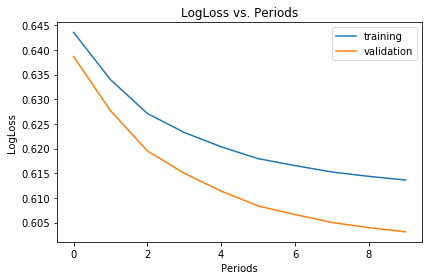

In [55]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.59
  period 02 : 0.59
  period 03 : 0.58
  period 04 : 0.58
  period 05 : 0.57
  period 06 : 0.57
  period 07 : 0.57
  period 08 : 0.56
  period 09 : 0.56
Model training finished.
AUC on the validation set: 0.66
Accuracy on the validation set: 0.75


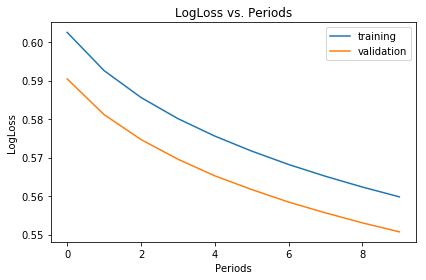

In [56]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])